In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


### 루브릭

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
- 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.

2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
- 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.

3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
- 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [6]:
#synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [7]:
print(len(tokenized))

71156


# STEP 2. 추출된 결과로 embedding model 만들기

In [8]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.9006224870681763),
 ('다큐멘터리', 0.8679867386817932),
 ('드라마', 0.8279436230659485),
 ('영화로', 0.8149978518486023),
 ('에마데딘', 0.7934910655021667),
 ('코미디', 0.7823933959007263),
 ('설정', 0.781464159488678),
 ('형식', 0.7791704535484314),
 ('감동', 0.7783337831497192),
 ('주제', 0.7728832960128784)]

# STEP 3. target, attribute 단어 셋 만들기

## 3-1) 모든 장르, 영화 구분 명사 추출 토큰화

In [4]:
#명사에 대해서만 추출하는 함수
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

### 영화 구분 토큰화

In [9]:
#모든 영화 구분과 파일 이름
film_text = ['synopsis_art.txt', 'synopsis_gen.txt']
film_name = ['예술영화','일반영화']



In [10]:
#모든 장르에 대해 명사 추출 후 딕셔너리에 저장
synopsises_film = { i:read_token(j) for i,j in zip(film_name, film_text)}

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


### 모든 장르 토큰화

In [3]:
#모든 장르와 파일 이름 가져오기
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [5]:
#모든 장르에 대해 명사 추출 후 딕셔너리에 저장
synopsises = { i:read_token(j) for i,j in zip(genre_name, genre_txt)}

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


# STEP 3. target, attribute 단어 셋 만들기

## 3-1) TF-IDF 및 대표단어 추출

### 영화 구분 별 TF-IDF, 대표단어 추출

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(synopsises_film.values())

print(X.shape)

(2, 41082)


In [30]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

In [31]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [32]:
print(target_art)
print(target_gen)

['오비', '좇는다', '역사학자', '북간도', '스파르타', '애착', '파이프', '갱도', '메탄가스', '농법', '생태계', '드레이크', '다프', '서퍼', '침잠']
['나르시스', '진혜', '뿌우람', '빅샤크', '초파리', '브랜슨', '용훈', '에이헵', '등자', '더트백', '바버라', '강하늘', '간트', '아스왕']


### 장르 별 TF-IDF, 대표단어 추출

In [33]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(synopsises.values())

print(X.shape)

(21, 42191)


In [34]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

# STEP 4. WEAT score 계산과 시각화

In [45]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [46]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [48]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [49]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [50]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [51]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 0.17788947
SF 공연 0.12504694
SF 공포(호러) 0.15298277
SF 기타 -0.13131419
SF 다큐멘터리 -0.510848
SF 드라마 0.027863149
SF 멜로로맨스 0.18655214
SF 뮤지컬 -0.19060487
SF 미스터리 0.24181284
SF 범죄 0.4188947
SF 사극 -0.02864942
SF 서부극(웨스턴) 0.0849639
SF 성인물(에로) 0.18873629
SF 스릴러 0.32058868
SF 애니메이션 -0.12963638
SF 액션 0.26435724
SF 어드벤처 -0.2819344
SF 전쟁 -0.012955714
SF 코미디 0.013406085
SF 판타지 -0.152209
가족 공연 -0.13899615
가족 공포(호러) -0.030010838
가족 기타 -0.42915902
가족 다큐멘터리 -0.5729756
가족 드라마 -0.41289324
가족 멜로로맨스 0.15864126
가족 뮤지컬 -0.5325206
가족 미스터리 0.20431325
가족 범죄 0.50068367
가족 사극 -0.4935334
가족 서부극(웨스턴) -0.3110423
가족 성인물(에로) 0.16384672
가족 스릴러 0.41048643
가족 애니메이션 -0.43541163
가족 액션 0.12824415
가족 어드벤처 -0.93234354
가족 전쟁 -0.18586628
가족 코미디 -0.42812607
가족 판타지 -0.59828687
공연 공포(호러) 0.052292112
공연 기타 -0.44575623
공연 다큐멘터리 -0.5734854
공연 드라마 -0.22189307
공연 멜로로맨스 0.18827616
공연 뮤지컬 -0.61944234
공연 미스터리 0.22425173
공연 범죄 0.5490779
공연 사극 -0.39561054
공연 서부극(웨스턴) -0.10435972
공연 성인물(에로) 0.20149106
공연 스릴러 0.39996943
공연 애니메이션 -0.41588816
공

<AxesSubplot:>

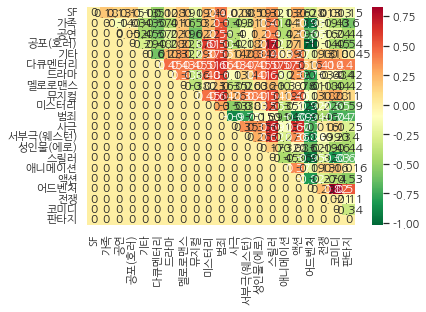

In [53]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

In [54]:
# 타겟 단어 및 속성 단어 세트 정의
target_words = ['남성', '여성']  # 남자, 여자 단어 사용 (복수형 제거)
attribute_words = [['남자', '남성', '그는', '그의'], ['여자', '여성', '그녀', '그녀의']]  # 남/녀 관련 단어 추가